Experiment with architectures Gustavo Alfredo Zarate Acosta

In [ ]:
import numpy as np
import pandas as pd
import torch
import fastai.vision.all as fv
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn as nn
from pathlib import Path
from fastai.vision.all import *


to_tensor = ToTensor()
to_pil = ToPILImage()

/usr/local/lib/python3.6/dist-packages/fastcore/foundation.py:52: UserWarning: `patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead
  warnings.warn("`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead")


In [ ]:
def load_data(path, size, bs):
    tfms = fv.aug_transforms(size = size,
                             flip_vert=False, 
                             max_rotate=10, 
                             max_lighting=0.3, 
                             max_zoom=1.2,
                             max_warp=0.1)
    
    h,w = [int(2*t) for t in size]
    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label,
                        splitter  = fv.GrandparentSplitter(),
                        item_tfms = fv.Resize((h,w)),
                        batch_tfms= tfms,
                     )
    return data.dataloaders(path, bs=bs)

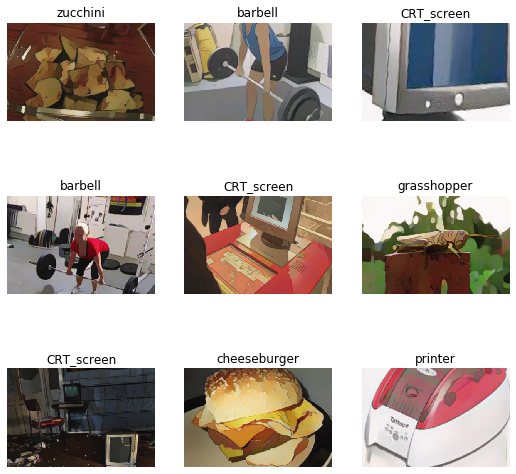

In [ ]:
data = load_data("CartoonImagenette",(256,384),64)
data.show_batch()

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.reshape(x.shape[0],-1)

#La version del jupyter de gradient no tiene math.prod
def num_params(model):
    total = 0
    for p in model.parameters():
        num = 1
        for s in list(p.size()):
            num *= s
        total += num
    return total

In [ ]:
model = nn.Sequential(
    nn.BatchNorm2d(3,momentum = 0.1),
    nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size = 1, stride = 1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64,momentum = 0.1),
    nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128,momentum = 0.1),
    nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256,momentum = 0.1),
    nn.ConvTranspose2d(256, 512, kernel_size = 3, stride = 1, padding=1),
    nn.BatchNorm2d(512,momentum = 0.1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Linear(256,128),
    nn.LeakyReLU(),
    nn.Linear(128,64),
    nn.LeakyReLU(),
    nn.Linear(64, data.c)
)

In [ ]:
num_params(model)

1727508

In [ ]:
learn = fv.Learner( data, model, opt_func = fv.ranger, metrics = fv.accuracy).to_fp16()

In [ ]:
#learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=10e-3, div=0.4,div_final=10000,pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,2.069185,2.008935,0.254286,02:11
1,1.915513,1.884404,0.332857,02:14
2,1.815300,1.882849,0.325714,02:13
3,1.711656,2.396524,0.237143,02:13
4,1.624480,1.601197,0.395714,02:14
5,1.562259,1.620196,0.388571,02:14
6,1.471455,1.482685,0.424286,02:18
7,1.434124,1.445793,0.440000,02:21
8,1.357188,1.374749,0.467143,02:27
9,1.263074,1.308882,0.477143,02:26
